In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytz import timezone


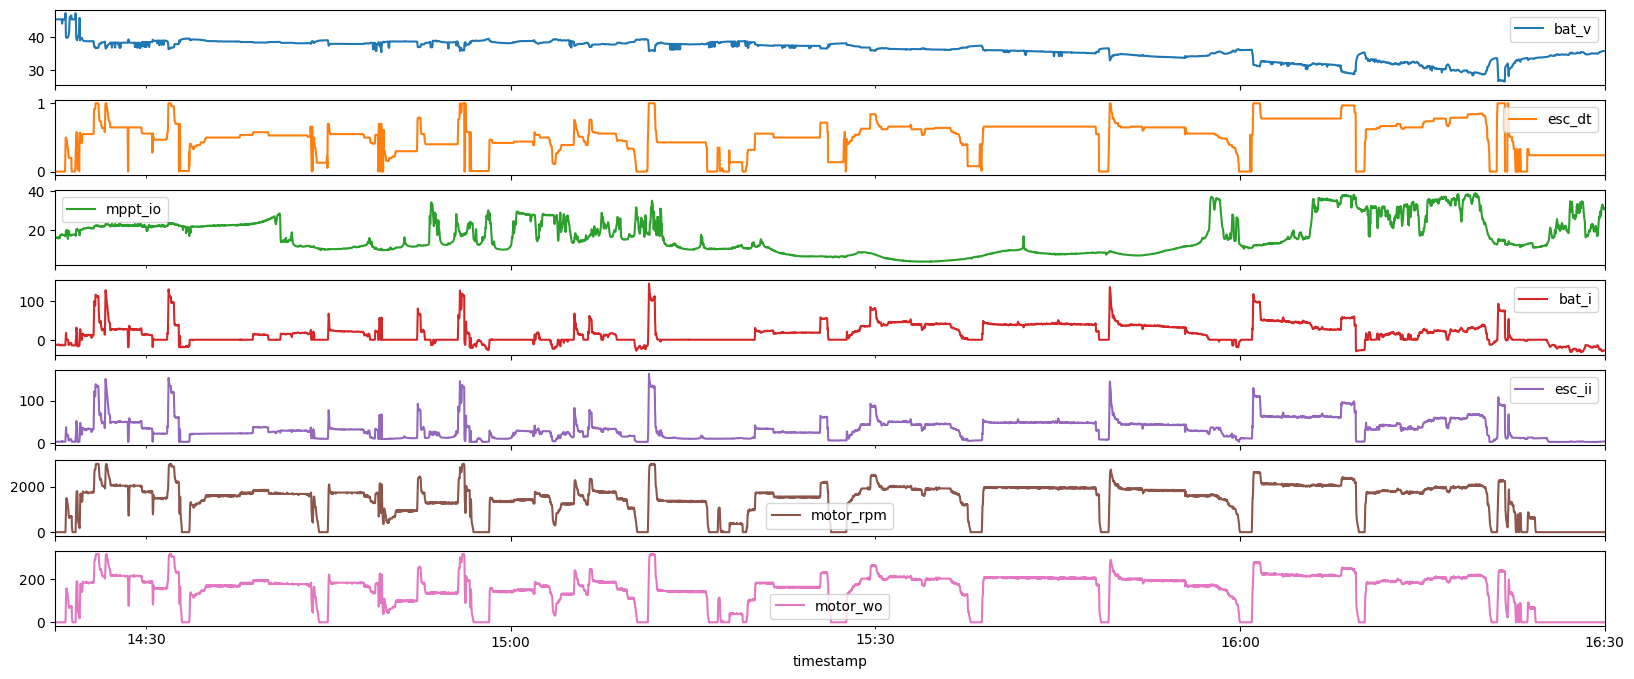

In [2]:
tzinfo = timezone("America/Sao_Paulo")
# start = pd.Timestamp(
#     year=2020, month=1, day=31, hour=12, minute=9, second=0, tzinfo=tzinfo
# ).tz_convert(None)
# end = pd.Timestamp(
#     year=2020, month=1, day=31, hour=12, minute=13, second=0, tzinfo=tzinfo
# ).tz_convert(None)

start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

df = pd.read_csv("../../../models/2020/boat_data_1s.csv")
# df = pd.read_csv("../../../models/2020/boat_data_100ms.csv")
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")

df = df.loc[
    (df.index >= start) & (df.index <= end),
    ["bat_v", "esc_dt", "mppt_io", "bat_i", "esc_ii", "motor_rpm"],
]
df = df.interpolate(method="time")

rpm_to_radps = (2 * np.pi) / 60
df["motor_wo"] = df["motor_rpm"] * rpm_to_radps

df.plot(subplots=True, figsize=(20, 8))
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from nfoursid.nfoursid import NFourSID

pd.set_option('display.max_columns', None)
np.random.seed(0)  # reproducable results

# Store only useful columns
u_column_names = ["esc_dt", "bat_v"]
y_column_names = ["esc_ii", "motor_wo"]
df = df[[*u_column_names, *y_column_names]]

# Slipt train/test
train_size = int(len(df) * 0.5)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

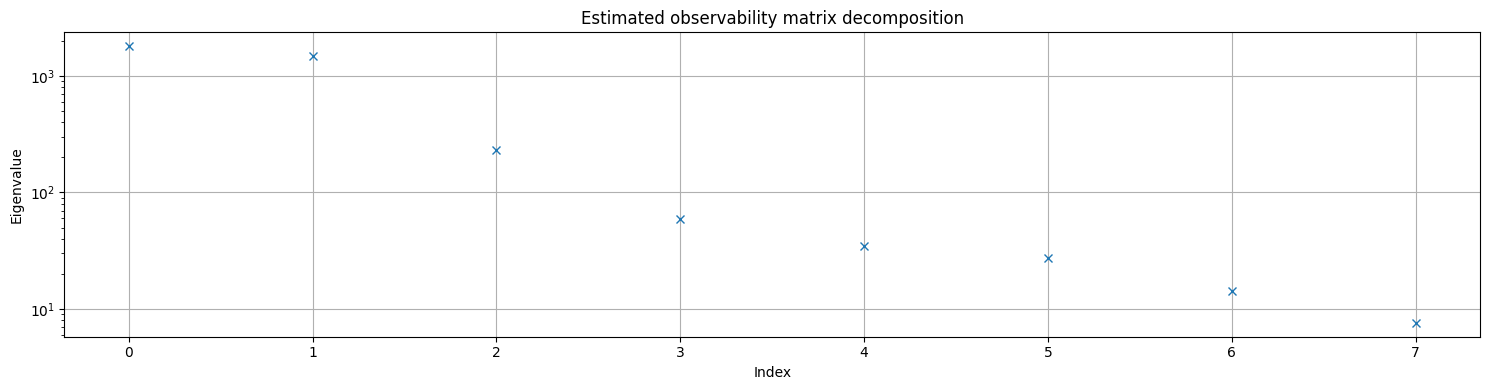

In [4]:
# Create and identify the model
nfoursid = NFourSID(
    df_train,
    output_columns=y_column_names,
    input_columns=u_column_names,
    num_block_rows=4
)
nfoursid.subspace_identification()

fig, ax = plt.subplots(figsize=(15,4))
nfoursid.plot_eigenvalues(ax)
fig.tight_layout()

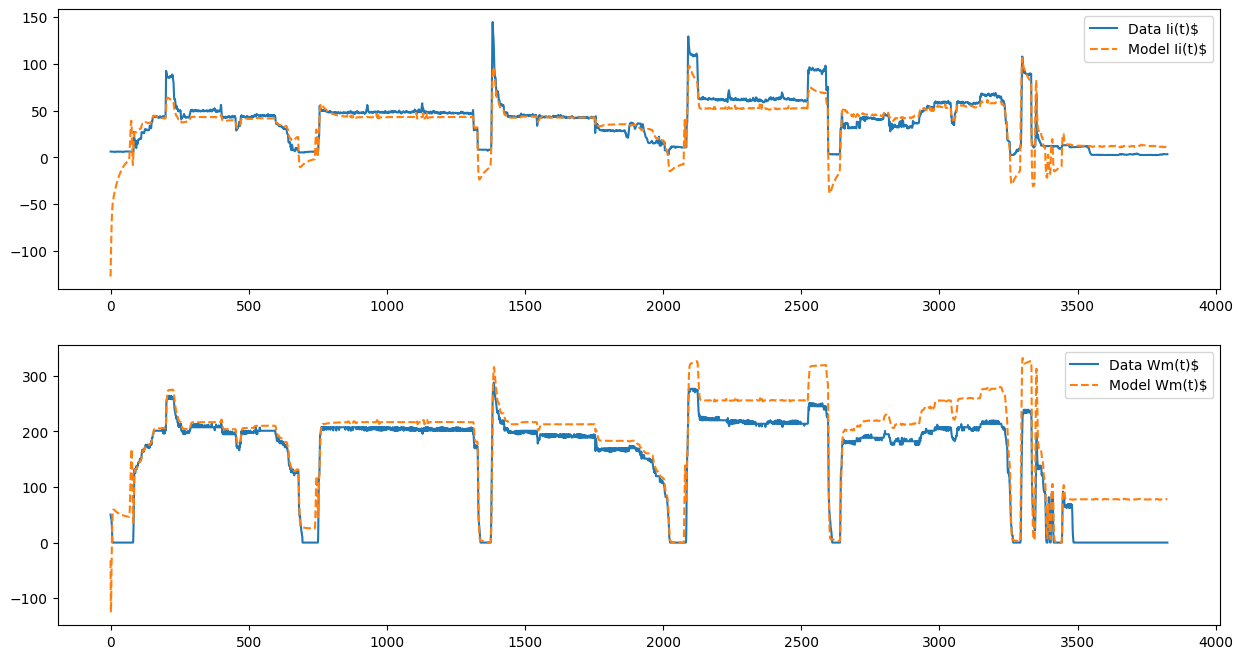

In [5]:
ORDER_OF_MODEL_TO_FIT = 3
state_space_identified, covariance_matrix = nfoursid.system_identification(
    rank=ORDER_OF_MODEL_TO_FIT
)

T = (df_test.index - df_test.index[0]).to_numpy().astype(
    np.float64
) * 1e-9  # simulation time in seconds
U = df_test[[*u_column_names]].to_numpy()
for i in range(len(U)):
    state_space_identified.step(U[i].reshape(2,1))

df_pred = state_space_identified.to_dataframe()

fig, ax = plt.subplots(2, figsize=(15,8))

ax[0].plot(T, df_test["esc_ii"], label=f"Data Ii(t)$")
ax[0].plot(T, df_pred["$y_0$"], "--", label=f"Model Ii(t)$")
ax[0].legend(loc=1)

ax[1].plot(T, df_test["motor_wo"], label=f"Data Wm(t)$")
ax[1].plot(T, df_pred["$y_1$"], "--", label=f"Model Wm(t)$")
ax[1].legend(loc=1)

plt.show()

StateSpace(array([[ 0.83575158, -0.08451797, -0.05674397],
       [ 0.48276642,  0.62435178, -0.2946805 ],
       [ 0.99183963, -0.39345298,  0.59904877]]), array([[-0.74613585, -0.0029436 ],
       [-0.68203879,  0.0439391 ],
       [ 0.32032815,  0.06921136]]), array([[-51.4857892 ,  18.73657892, -10.08395049],
       [-64.74321316, -39.60388692, -17.04508902]]), array([[40.77306091, -3.51989609],
       [10.49776411, -0.8855711 ]]), 0.1)

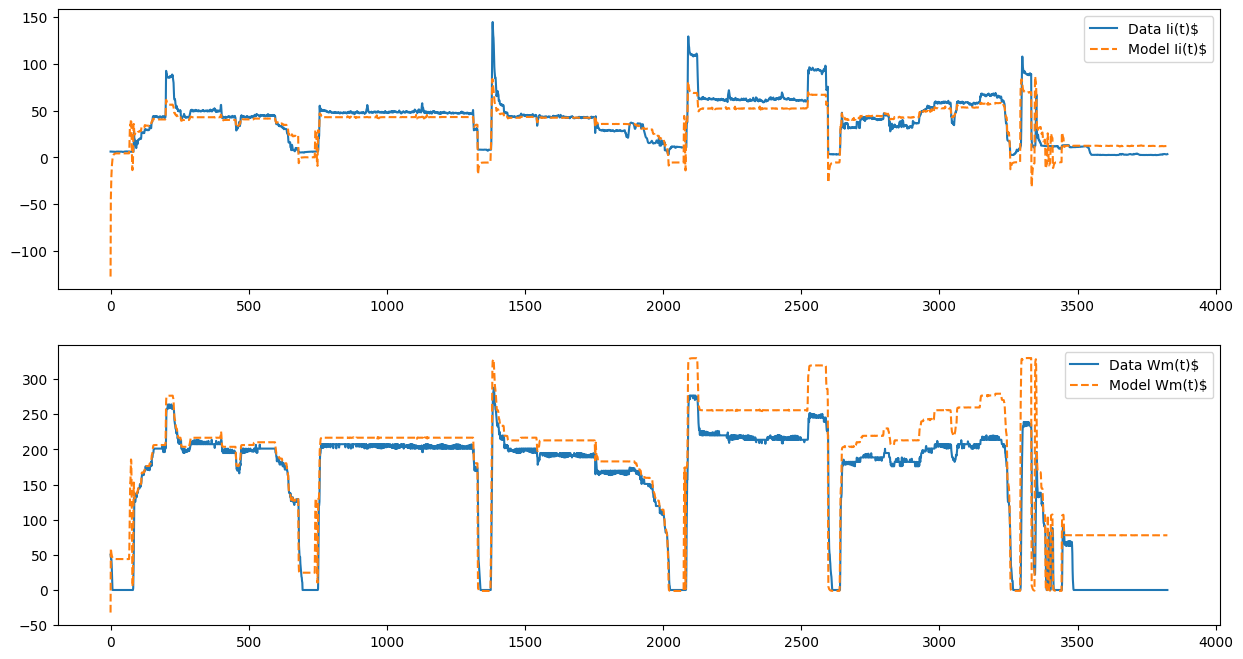

In [7]:
import control as ct

sys = ct.StateSpace(
    state_space_identified.a,
    state_space_identified.b,
    state_space_identified.c,
    state_space_identified.d,
    inputs=u_column_names,
    outputs=y_column_names,
    dt=100e-3,
)
display(sys)

res = ct.forced_response(sys, T, U=df_test[[*u_column_names]].to_numpy().T)
res.output_labels = sys.output_labels
res.input_labels = sys.input_labels
res.state_labels = sys.state_labels
outputs = res.to_pandas().set_index("time")

fig, ax = plt.subplots(2, figsize=(15,8))

ax[0].plot(T, df_test["esc_ii"], label=f"Data Ii(t)$")
ax[0].plot(T, outputs["esc_ii"], "--", label=f"Model Ii(t)$")
ax[0].legend(loc=1)

ax[1].plot(T, df_test["motor_wo"], label=f"Data Wm(t)$")
ax[1].plot(T, outputs["motor_wo"], "--", label=f"Model Wm(t)$")
ax[1].legend(loc=1)

plt.show()